#### Connecting to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Importing Libraries

Scikit-learn is a free software machine learning library for the Python programming language. It features various classification, regression and clustering algorithms including support vector machines, random forests, gradient boosting, k-means and DBSCAN.


Matplotlib is a plotting library for the Python programming language and its numerical mathematics extension NumPy. It provides an object-oriented API for embedding plots into applications using general-purpose GUI toolkits like Tkinter, wxPython, Qt, or GTK.

SciPy is a free and open-source Python library used for scientific computing and technical computing. It is a collection of mathematical algorithms and convenience functions built on the NumPy extension of Python.

tqdm is a Python library that allows you to output a smart progress bar by wrapping around any iterable. A tqdm progress bar not only shows you how much time has elapsed, but also shows the estimated time remaining for the iterable.

Pillow is a fork of the Python Imaging Library (PIL). PIL is a library that offers several standard procedures for manipulating images.

Python Random module is an in-built module of Python which is used to generate random numbers. These are pseudo-random numbers means these are not truly random. This module can be used to perform random actions such as generating random numbers, print random a value for a list or string, etc.

In [ ]:
import os
import skimage.io as sk
import matplotlib.pyplot as plt
from scipy import spatial
from tqdm import tqdm
from PIL import Image
from random import shuffle

import numpy as np
import pandas as pd

#### Connecting to the Alaska-2 Dataset

In [ ]:
BASE_PATH = "/content/drive/My Drive//Datasets/AICS/Project/alaska2_dataset"
train_imageids = pd.Series(os.listdir(BASE_PATH + '/Cover')).sort_values(ascending=True).reset_index(drop=True)
test_imageids = pd.Series(os.listdir(BASE_PATH + '/Test')).sort_values(ascending=True).reset_index(drop=True)

### Contents of the Dataset

UNIWARD - Universal Wavelet Relative Distortion

JMiPOD - Paper describing CNN for Stegnanalysis of JMiPOD images

UERD - Uniform Embedding Revisited Distortion

JMIPOD images is similar between cover and JMIPOD images , JUNIWARD images is similar between cover and JUNIWARD images, UERD images is similar between cover and UERD images.


Cover contains unaltered images meant for training.

JMiPOD contains examples of the JMiPOD algorithm applied to the cover images.

JUNIWARD contains examples of the JUNIWARD algorithm applied to the cover images.

UERD contains examples of the UERD algorithm applied to the cover images.

Test contains test set of images. These are the images which will be used for prediction.

In [ ]:
cover_images_path = pd.Series(BASE_PATH + '/Cover/' + train_imageids ).sort_values(ascending=True)
JMIPOD_images_path = pd.Series(BASE_PATH + '/JMiPOD/'+train_imageids).sort_values(ascending=True)
JUNIWARD_images_path = pd.Series(BASE_PATH + '/JUNIWARD/'+train_imageids).sort_values(ascending=True)
UERD_images_path = pd.Series(BASE_PATH + '/UERD/'+train_imageids).sort_values(ascending=True)
test_images_path = pd.Series(BASE_PATH + '/Test/'+test_imageids).sort_values(ascending=True)
ss = pd.read_csv(f'{BASE_PATH}/sample_submission.csv')

## Building Model

What we will do?

In this technique we will flatten the RGB images(encoded and normal) into a vector and the find the cosine dissimilarity between the two vectors. If they are alike then cosine dissimilarity(1-similarity) must be 1, else it will be less than 1 and we can get an idea that the image is hiding something.

In [ ]:
final=[]
def create_labels(cover,jmipod,juniward,uerd,image_id):
    image = sk.imread(cover)
    jmipodimg = sk.imread(jmipod)
    juniward = sk.imread(juniward)
    uerd = sk.imread(uerd)
    
    vec1 = np.reshape(image,(512*512*3))
    vec2 = np.reshape(jmipodimg,(512*512*3))
    vec3 = np.reshape(juniward,(512*512*3))
    vec4 = np.reshape(uerd,(512*512*3))
    
    cos1 = spatial.distance.cosine(vec1,vec2)
    cos2 = spatial.distance.cosine(vec1,vec3)
    cos3 = spatial.distance.cosine(vec1,vec4)
    
    final.append({'image_id':image_id,'jmipod':cos1,'juniward':cos2,'uerd':cos3})

#### Importing first 4000 images.

In [ ]:
for k in tqdm(range(4000)):
  create_labels(cover_images_path[k],JMIPOD_images_path[k],JUNIWARD_images_path[k],UERD_images_path[k],train_imageids[k])

100%|██████████| 4000/4000 [53:41<00:00,  1.24it/s]


#### Printing the Cosine Dissimilarity

In [ ]:
train_temp = pd.DataFrame(final)
train_temp.head()

,image_id,jmipod,juniward,uerd
0,00001.jpg,-0.072243,-0.043371,-0.055197
1,00002.jpg,-0.046725,-0.105272,-0.091790
2,00003.jpg,-0.067416,-0.025235,-0.021030
3,00004.jpg,-0.115326,-0.118881,-0.115003
4,00005.jpg,-0.005886,-0.004440,-0.003662


#### Adding Softmax to our Dissimilarity to get Probabilities

In [ ]:
def sigmoid(X):
   return 1/(1+np.exp(-X))

In [ ]:
train_temp['jmipod'] = train_temp['jmipod'].apply(lambda x:sigmoid(x))
train_temp['juniward'] = train_temp['juniward'].apply(lambda x:sigmoid(x))
train_temp['uerd'] = train_temp['uerd'].apply(lambda x:sigmoid(x))

In [ ]:
train_temp.head()

,image_id,jmipod,juniward,uerd
0,00001.jpg,0.481947,0.489159,0.486204
1,00002.jpg,0.488321,0.473706,0.477069
2,00003.jpg,0.483152,0.493692,0.494743
3,00004.jpg,0.471200,0.470315,0.471281
4,00005.jpg,0.498529,0.498890,0.499085


#### Creating a Data Holder

In [ ]:
IMG_SIZE = 300
def load_training_data():
  train_data = []
  data_paths = [cover_images_path,JUNIWARD_images_path,JMIPOD_images_path,UERD_images_path]
  labels = [np.zeros(train_temp.shape[0]),train_temp['juniward'],train_temp['jmipod'],train_temp['uerd']]
  for i,image_path in enumerate(data_paths):
    for j,img in enumerate(image_path[:1000]):
        label = labels[i][j]
        img = Image.open(img)
        img = img.convert('L')
        img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
        train_data.append([np.array(img), label])
        
  shuffle(train_data)
  return train_data

In [ ]:
def load_test_data():
    test_data = []
    for img in test_images_path:
        img = Image.open(img)
        img = img.convert('L')
        img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
        test_data.append([np.array(img)])
            
    return test_data

In [ ]:
train = load_training_data()

In [ ]:
len(train)

4000

#### Printing an Image from Training set

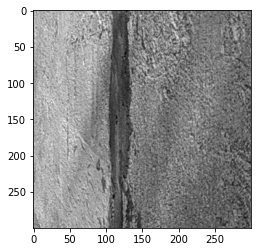

In [ ]:
plt.imshow(train[115][0], cmap = 'gist_gray')

In [ ]:
trainImages = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
trainLabels = np.array([i[1] for i in train])

## CNN Model
Convolutional neural network (CNN/ConvNet) is a class of deep neural networks which is most commonly applied to analyze visual imagery. It uses a special technique called Convolution. In mathematics, Convolution is a mathematical operation on two functions that produces a third function that expresses how the shape of one is modified by the other.

Convolutional neural networks are composed of multiple layers of artificial neurons. Artificial neurons, a rough imitation of their biological counterparts, are mathematical functions that calculate the weighted sum of multiple inputs and outputs an activation value.

### Why use CNN?

CNN follows a hierarchical model which works on building a network, like a funnel, and finally gives out a fully-connected layer where all the neurons are connected to each other and the output is processed.

Using an ANN for any purpose related to images would end up being very costly in terms of computation since the trainable parameters become extremely large.

We use CNN as it contains filters (there are many different types according to purpose). Filters help us exploit the spatial locality of a particular image by enforcing a local connectivity pattern between neurons.


#### Importing CNN Libraries

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

#### Using 5 Conv2D layers with Max Pooling and BatchNormalization

Pooling Layer: Pooling layer is responsible for reducing the spatial size of the Convolved Feature. This is to decrease the computational power required to process the data by reducing the dimensions.
In Max Pooling, we find the maximum value of a pixel from a portion of the image covered by the kernel. Max Pooling also performs as a Noise Suppressant. It discards the noisy activations altogether and also performs de-noising along with dimensionality reduction.

BatchNormalization: Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1))

#### Compiling the Model

In [ ]:
optimizer = Adam(learning_rate=0.001)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics = ['accuracy'])

#### Summary of the Model

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 149, 149, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 73, 73, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        3

#### Training the Model

In [ ]:
model.fit(trainImages, trainLabels, batch_size = 100, epochs = 10, verbose = 1)

Epoch 1/10
40/40 [==============================] - 553s 14s/step - loss: 4.3793e-08 - accuracy: 0.6724
Epoch 2/10
40/40 [==============================] - 553s 14s/step - loss: 4.3792e-08 - accuracy: 0.6752
Epoch 3/10
40/40 [==============================] - 553s 14s/step - loss: 4.3795e-08 - accuracy: 0.6828
Epoch 4/10
40/40 [==============================] - 553s 14s/step - loss: 4.3791e-08 - accuracy: 0.6753
Epoch 5/10
40/40 [==============================] - 553s 14s/step - loss: 4.3797e-08 - accuracy: 0.6789
Epoch 6/10
40/40 [==============================] - 553s 14s/step - loss: 4.3792e-08 - accuracy: 0.6833
Epoch 7/10
40/40 [==============================] - 553s 14s/step - loss: 4.3791e-08 - accuracy: 0.6779
Epoch 8/10
40/40 [==============================] - 553s 14s/step - loss: 4.3792e-08 - accuracy: 0.6741
Epoch 9/10
40/40 [==============================] - 553s 14s/step - loss: 4.3793e-08 - accuracy: 0.6832
Epoch 10/10
40/40 [==============================] - 553s 14s/st

In [ ]:
test = load_test_data()
testImages = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
trainLabels = np.array([i[1] for i in train])

In [ ]:
predict = model.predict(testImages,batch_size=100)

In [ ]:
predict

array([[ 0.36390918],
       [ 0.69789404],
       [ 1.3247591 ],
       ...,
       [ 1.8220463 ],
       [-0.06519279],
       [-5.9193964 ]], dtype=float32)

In [ ]:
loss_v, accuracy_v = model.evaluate(testImages, testLabels, verbose=1)
print("Accuracy = %f" % (accuracy_v))

125/125 [==============================] - 134s 1s/step - loss: 4.3793e-08 - accuracy: 0.6717
Accuracy = 0.671750
